# Import, Init

In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(0, "./classes/")
import cls_nnetwork

# reloading functions without runtime.restart
import importlib
importlib.reload(cls_nnetwork)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tbzatt66 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<module 'cls_nnetwork' from './classes/cls_nnetwork.py'>

In [2]:
# cut -- train test data with trimmed columns, so that it's more easy to train

nn_manager_cut = cls_nnetwork.NeuralManager(dir_path='../data/csv_to_train/train_test_cut/')

>>> train-test inited:  {'y_test': True, 'X_test': True, 'y_train': True, 'X_train': True}


In [3]:
nn_manager_cut.X_test.columns

Index(['Open', 'High', 'Low', 'Vol', 'AVBLS', 'NTRAT', 'TOUTV', 'TRFEE',
       'BTC_MINED_PDAY', 'VOL_CHANGE_PDAY', 'MWNUS_CH_PDAY', 'NTRAT_CH_PDAY'],
      dtype='object')

# Preparing data

## Normalizing

In [4]:
from sklearn.preprocessing import RobustScaler

nn_manager_cut.normalize_X(scaler=RobustScaler)

nn_manager_cut.X_train_normalized[:2]

array([[-0.35788468, -0.36106367, -0.36592223, -0.58401698, -0.43077291,
        -0.28358634, -0.82919494, -0.64760888,  2.76317136,  0.03411234,
        -0.32110596, -0.22554355],
       [-0.35778409, -0.36106367, -0.36592223, -0.57780875, -0.43056673,
        -0.28358294, -0.83411168, -0.65625833,  1.16726343,  0.00787208,
        -0.32110596, -0.23042704]])

## Unrolling data to sequences
[[to #Model-fit]](#Model-fit)

In [5]:
nn_manager_cut.set_train_test_data_shapes(shape_kwargs=dict(seq_len=4))

self.training_seq_params -->  {'seq_len': 4, 'n_features': 12}
self.X_train_shape -->  [4, 12]
self.X_test_shape -->  [4, 12]


True

In [6]:
nn_manager_cut.unroll_train_test_to_sequences()

In [7]:
nn_manager_cut.X_test_unrolled[1]

array([[ 4.5733397 ,  4.5467675 ,  4.82022174, 10.20613854,  1.28184017,
         1.87952864, -0.04548318,  2.5474734 , -0.23836317,  3.31316113,
         1.30698295,  1.48368537],
       [ 4.68146956,  4.71168578,  4.88345446, 11.4789522 ,  1.24140549,
         1.88162712, -0.27668704,  1.59950791, -0.40613811, -3.6198442 ,
         2.99879035,  1.35947304],
       [ 4.71778107,  4.73227616,  4.97448411, 10.07373856,  1.14087063,
         1.88357335, -0.2339349 ,  1.7297756 ,  0.08286445,  2.8703567 ,
         2.62804179,  1.32794069],
       [ 4.84592753,  4.81141742,  5.00291762, 11.17550917,  1.25063089,
         1.88548092,  0.26145216,  2.98612256, -0.25882353, -4.69241492,
         7.17938889,  1.42051883]])

In [8]:
# goes up by one sequence -- compare this cell result vs previous
nn_manager_cut.X_test_unrolled[2]

array([[ 4.68146956,  4.71168578,  4.88345446, 11.4789522 ,  1.24140549,
         1.88162712, -0.27668704,  1.59950791, -0.40613811, -3.6198442 ,
         2.99879035,  1.35947304],
       [ 4.71778107,  4.73227616,  4.97448411, 10.07373856,  1.14087063,
         1.88357335, -0.2339349 ,  1.7297756 ,  0.08286445,  2.8703567 ,
         2.62804179,  1.32794069],
       [ 4.84592753,  4.81141742,  5.00291762, 11.17550917,  1.25063089,
         1.88548092,  0.26145216,  2.98612256, -0.25882353, -4.69241492,
         7.17938889,  1.42051883],
       [ 4.91784646,  4.75803855,  5.03973264,  9.35599126,  1.29602355,
         1.88750198,  0.62933247,  2.55033297, -0.37953964,  1.75284953,
         3.00180661,  1.30012297]])

In [9]:
# on the base of the first two elements of the sequence we want to predict the third's day price

nn_manager_cut.y_test.iloc[:6], nn_manager_cut.y_test_unrolled[:6]

(             Price
 Date              
 2019-04-04  4902.4
 2019-04-05  5010.2
 2019-04-06  5046.2
 2019-04-07  5173.6
 2019-04-08  5245.2
 2019-04-09  5158.4,
 array([[5245.2],
        [5158.4],
        [5307.8],
        [5022.6],
        [5054.2],
        [5051.8]]))

# Model

## Model Assembling

[n_seq-n_steps in MLM example elaboration](z_MlMastery%20LSTM%20for%20TS%20.ipynb#n_seq-n_steps)<br>
(We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. [[source]](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/#:~:text=We%20can%20parameterize%20this%20and))

### Architectures

#### Keras imports

In [10]:
from tensorflow.keras.layers import (
    LeakyReLU,
    TimeDistributed, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional,
    Dense, 
    Dropout, 
    BatchNormalization)
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras import regularizers

#### LSTM-based
[[Unrolling Seq Len]](#Unrolling-data-to-sequences)<br>
[[to #Model-fit]](#Model-fit)

In [11]:
input_model_shape=(nn_manager_cut.training_seq_params['seq_len'], nn_manager_cut.training_seq_params['n_features'])
input_model_shape

(4, 12)

In [12]:
# LSTM Architecture

weights_init = GlorotNormal()

template_Stacked_LSTM = [
    Bidirectional(
        LSTM(30, activation=LeakyReLU(alpha=0.35), 
             kernel_initializer=weights_init, 
#              return_sequences=True,
#              input_shape=input_model_shape             
            ),
         input_shape=input_model_shape),
#     ),
#     LSTM(10, activation=LeakyReLU(alpha=0.35)),    
    Dense(5),    
    Dense(2),
    Dense(1)
]

In [13]:
nn_manager_cut.X_train_unrolled.shape

(3178, 4, 12)

### Compiling Model with the chosen Architecture

In [14]:
# Assembling and compiling model

from tensorflow import keras

opt_adam = keras.optimizers.Adam(
    learning_rate=3e-5, #wo BatchNorm
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False, 
)

training_params = dict(optimizer=opt_adam, loss=keras.losses.Huber(delta=.5), metrics=['mae']) # huber loss as per outliers


nn_manager_cut.model_combine(template=template_Stacked_LSTM, compile_dict=training_params)

>>> model compiled
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60)                10320     
_________________________________________________________________
dense (Dense)                (None, 5)                 305       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 10,640
Trainable params: 10,640
Non-trainable params: 0
_________________________________________________________________


True

## Model Training

#### Model fit

In [15]:
nn_manager_cut.X_train_shape, nn_manager_cut.X_test_shape, 

([3178, 4, 12], [791, 4, 12])

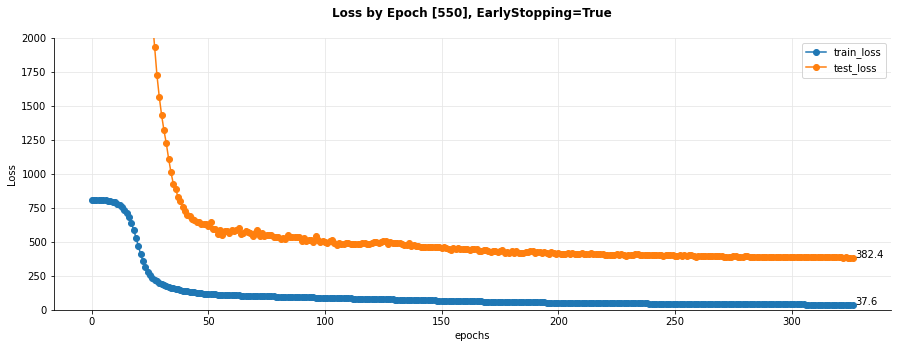

In [16]:
# %%time
nn_manager_cut.model_fit(n_epoch=550,
                           verbose=0, 
                           return_results=True, 
                           print_charts=True,
                           early_stopping=True
                        );
plt.ylim(0,2e3);

Architectures: <br>
[[#Stacked-LSTM_Architecture]](#LSTM-based)

Model Compiling setup [[go]](#Compiling-Model-with-the-chosen-Architecture)<br>
Unrolling Seq Len [[go]](#Unrolling-data-to-sequences)<br>

# Saving Model

In [17]:
from datetime import datetime

# nn_manager_cut.model.save(f'./saved_models/{datetime.now().strftime("%Y%m%d_%HH%MM%SS")}_363_Bidi')

### Plotting 

In [18]:
# nn_manager_cut.X_train_unrolled[:2]

In [19]:
# pred_price = []
# for seq in nn_manager_cut.X_test_unrolled:
#     pred_price.append(nn_manager_cut.model_predict(seq.reshape(1,4,12))[0][0])

In [20]:
# pred_price[0]

In [21]:
# test_y = pd.DataFrame(data=nn_manager_cut.y_test_unrolled, index=nn_manager_cut.y_test[nn_manager_cut.training_seq_params['seq_len']:].index)
# test_y[:5]

In [22]:
# pd.DataFrame(index=test_y.index, data=[
#                 nn_manager_cut.model_predict(seq.reshape(1,
#                                                nn_manager_cut.training_seq_params['seq_len'],
#                                                nn_manager_cut.training_seq_params['n_features']))[0][0] 
#                                 for seq in nn_manager_cut.X_test_unrolled], 
#                     )

In [23]:
# pred_price = pd.DataFrame(data=pred_price, index=nn_manager_cut.y_test[sequence_len:].index, columns=['Price_predicted'])

In [24]:
# # fig, ax = plt.subplots(2, figsize=(15,5))
# plt.plot(nn_manager_cut.y_test[sequence_len:], label="Act Price")
# plt.plot(pred_price, label="Pred Price")

# fig = plt.gcf()
# fig.set_size_inches(18.5, 10.5)
# plt.legend(loc='lower right')

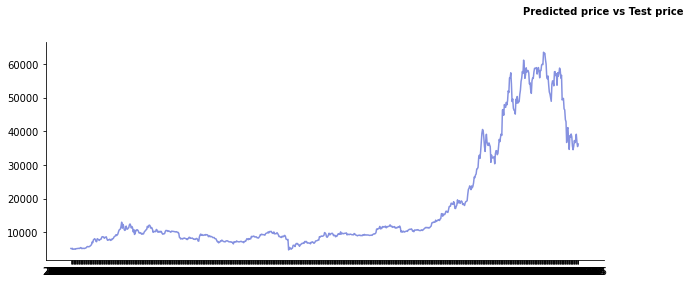

In [25]:
nn_manager_cut.plot_predicted_vs_test_price()